<a href="https://colab.research.google.com/github/tohpedo/wikibot/blob/main/transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#install depedencies hugging face
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers
#!pip install folium

#import required packages
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [16]:
#import helper functions for squad dataset
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'

from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

--2021-11-02 11:02:29--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41529 (41K) [text/plain]
Saving to: ‘utils_squad.py’

utils_squad.py      100%[===================>]  40.56K  --.-KB/s    in 0.003s  

2021-11-02 11:02:29 (14.0 MB/s) - ‘utils_squad.py’ saved [41529/41529]

--2021-11-02 11:02:29--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 2

In [17]:
def isGPUAvailable():
  #check if GPU is available 
  gpu = tf.test.gpu_device_name()
  if gpu != '/device:GPU:0':
    print('No GPU available')
  else:
    print('GPU is available')

isGPUAvailable()

GPU is available


In [18]:
#mount colab drive
from google.colab import drive
drive.mount('/content/drive/')
!ls

Mounted at /content/drive/
drive  __pycache__  sample_data  utils_squad_evaluate.py  utils_squad.py


In [ ]:
#set seeds
np.random.seed(1234)
torch.manual_seed(1234)

In [23]:
#read in training data
train_data_file = '/content/drive/My Drive/train-v2.0.json'
train_data_raw = read_squad_examples(input_file=train_data_file,
                                is_training=True,
                                version_2_with_negative=True)

In [27]:
#inspecting first records
sample_records = train_data_raw[:5]
sample_records

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [30]:
#take first 10,000 rows for training due to RAM limitation
train_data_raw = train_data_raw[:10000]
train_data = pd.DataFrame.from_records([vars(record) for record in train_data_raw])
train_data.head()
print(len(train_data))

130319


In [35]:
#loooking at all questions from one article
sample = train_data.sample(frac=1).head(1)
print(sample)
context = sample.doc_tokens.values
print(context)
train_data[train_data.doc_tokens.values==context]


                          qas_id  ... is_impossible
123912  5a53e21dbdaabd001a3867b5  ...          True

[1 rows x 7 columns]
[list(['While', 'the', 'Armenian', 'Apostolic', 'Church', 'remains', 'the', 'most', 'prominent', 'church', 'in', 'the', 'Armenian', 'community', 'throughout', 'the', 'world,', 'Armenians', '(especially', 'in', 'the', 'diaspora)', 'subscribe', 'to', 'any', 'number', 'of', 'other', 'Christian', 'denominations.', 'These', 'include', 'the', 'Armenian', 'Catholic', 'Church', '(which', 'follows', 'its', 'own', 'liturgy', 'but', 'recognizes', 'the', 'Roman', 'Catholic', 'Pope),', 'the', 'Armenian', 'Evangelical', 'Church,', 'which', 'started', 'as', 'a', 'reformation', 'in', 'the', 'Mother', 'church', 'but', 'later', 'broke', 'away,', 'and', 'the', 'Armenian', 'Brotherhood', 'Church,', 'which', 'was', 'born', 'in', 'the', 'Armenian', 'Evangelical', 'Church,', 'but', 'later', 'broke', 'apart', 'from', 'it.', 'There', 'are', 'other', 'numerous', 'Armenian', 'churches', '

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
123905,57323937e17f3d140042273f,Which Armenian church recognizes the Pope?,"[While, the, Armenian, Apostolic, Church, rema...",Armenian Catholic Church,33,35,False
123906,57323937e17f3d1400422740,What broke away from the Armenian Apostolic Ch...,"[While, the, Armenian, Apostolic, Church, rema...",Armenian Evangelical Church,48,50,False
123907,57323937e17f3d1400422741,What broke away from the Armenian Evangelical ...,"[While, the, Armenian, Apostolic, Church, rema...",Armenian Brotherhood Church,66,68,False
123908,57323937e17f3d1400422742,Which Armenian church is the most popular in A...,"[While, the, Armenian, Apostolic, Church, rema...",Armenian Apostolic Church,2,4,False
123909,5a53e21dbdaabd001a3867b2,Who does the Armenian Evangelical Church recog...,"[While, the, Armenian, Apostolic, Church, rema...",,-1,-1,True
123910,5a53e21dbdaabd001a3867b3,How was the Armenian Catholic Church formed?,"[While, the, Armenian, Apostolic, Church, rema...",,-1,-1,True
123911,5a53e21dbdaabd001a3867b4,What does the Armenian Evangelical Church follow?,"[While, the, Armenian, Apostolic, Church, rema...",,-1,-1,True
123912,5a53e21dbdaabd001a3867b5,What is the most popular Protestant church to ...,"[While, the, Armenian, Apostolic, Church, rema...",,-1,-1,True
123913,5a53e21dbdaabd001a3867b6,What church did the Armenian Apostolic Church ...,"[While, the, Armenian, Apostolic, Church, rema...",,-1,-1,True


In [36]:
#helper function to show all questions from single article, not sure if needed
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))



In [37]:
print_squad_sample(train_data)

CONTEXT: 
The gross state domestic product (GSDP) of Delhi at current prices for the year
2011-12 has been estimated at Rs 3.13 lakh crore, which is an increase of
18.7 per cent over the previous fiscal.
QUESTION:                                                                                            ANSWER:
What was the gross state domestic product of Delhi for 2011-12?                                      Rs 3.13 lakh crore
The GSDP of Delhi increased by what percentage over the previous year in 2011-12?                    18.7
In which fiscal year was the GSDP of Delhi estimated at Rs 3.13 lakh crore?                          2011-12
Did the GSDP of Delhi in 2011-12 increase or decrease from the previous fiscal year?                 increase


In [38]:
train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
61916,572773195951b619008f8a2c,Between what years did Jews increase to an est...,"[By, the, 1st, century,, Babylonia,, to, which...",200 CE – 500 CE,46,50,False,132,63
104961,57305376069b531400832061,How long was the recovery of industrial cities...,"[The, military, effectiveness, of, bombing, va...",most took from 10–15 days,179,183,False,222,58
5365,56d0a987234ae51400d9c404,"During his search for enlightenment, Gautama c...","[While, he, searched, for, enlightenment,, Gau...",the yoga practice of his teacher Kalama with w...,7,21,False,108,69
71365,5acf67a277cf76001a684d8c,What sort of capacitors have not traditionally...,"[Most, types, of, capacitor, include, a, diele...",,-1,-1,True,74,82
35548,570ad47c4103511400d59a4c,Who exercises sovereignty rights for Lancashire?,"[The, county, was, subject, to, significant, b...",Duke of Lancaster,128,130,False,145,48


In [39]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.19289589392184%


In [40]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 2106437.29B/s]


In [45]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16


features = convert_examples_to_features(examples=train_data_raw,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
torch.save(features, "/content/drive/My Drive/bert_train")


In [46]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [47]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [48]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [49]:
import glob
checkpoints = sorted(glob.glob('/content/drive/My Drive/checkpoint*-[0-9]*'))

In [50]:

global_step = 0
train_loss_set = []
tr_loss = 0.0
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

100%|██████████| 440473133/440473133 [00:12<00:00, 34378051.82B/s]


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [51]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0007,  0.0073,  0.0097,  ..., -0.0183, -0.0147,  0.0317],
        [-0.0116,  0.0325,  0.0431,  ...,  0.0036, -0.0513,  0.0181]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [52]:
#create AdamW optimizer to fine tune model
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [ ]:
num_train_epochs = 1

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/drive/My Drive/Medium/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

***** Running training *****
  Num examples = 144262
  Num Epochs = 1
  Batch size = 8
  Total optimization steps = 18032


Iteration:   0%|          | 1/18032 [00:00<33:12,  9.05it/s]/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:   6%|▌         | 1000/18032 [13:50<3:55:14,  1.21it/s]

Train loss: 1.9674549799263477



Iteration:   6%|▌         | 1001/18032 [13:52<5:59:46,  1.27s/it]

Saving model checkpoint to /drive/My Drive/Medium/checkpoint-1000



Iteration:  11%|█         | 2000/18032 [27:43<3:41:49,  1.20it/s]

Train loss: 1.7553653562068938



Iteration:  11%|█         | 2001/18032 [27:45<5:50:46,  1.31s/it]

Saving model checkpoint to /drive/My Drive/Medium/checkpoint-2000



Iteration:  17%|█▋        | 3000/18032 [41:37<3:28:15,  1.20it/s]

Train loss: 1.6530736211836339



Iteration:  17%|█▋        | 3001/18032 [41:39<5:36:27,  1.34s/it]

Saving model checkpoint to /drive/My Drive/Medium/checkpoint-3000



Iteration:  22%|██▏       | 3901/18032 [54:07<3:16:23,  1.20it/s]


In [ ]:
output_dir = 'content/drive/My Drive/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [ ]:
train_loss_set_ckpt = torch.load('content/drive/My Drive/checkpoint-final/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

FileNotFoundError: ignored

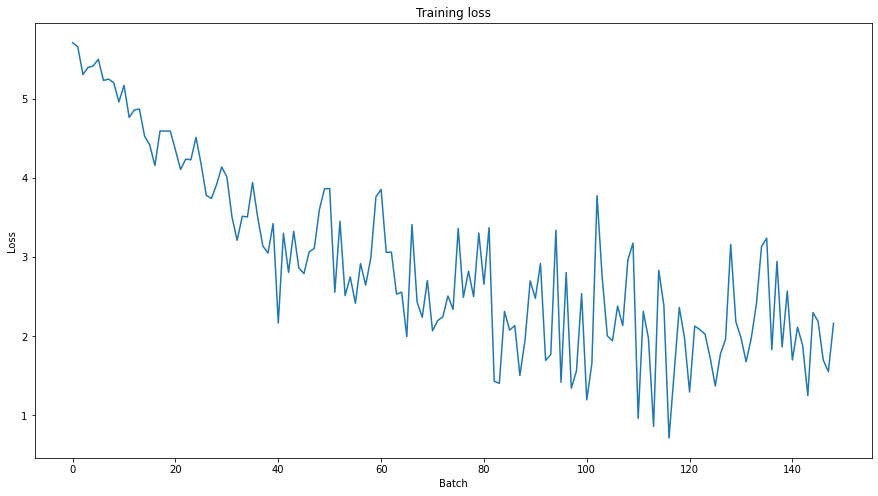

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
input_file = '/content/drive/My Drive/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True
                                )

doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/content/drive/My Drive/cache_validation'


# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [ ]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

In [ ]:
def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/content/drive/My Drive/dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/content/drive/My Drive/predictions.json"
  output_nbest_file = "/content/drive/My Drive/nbest_predictions.json"
  output_null_log_odds_file = "/content/drive/My Drive/null_odds.json"
  output_dir = "/content/drive/My Drive/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [ ]:
results = evaluate(model, tokenizer)

***** Running evaluation *****
  Num examples = 13600
  Batch size = 8


Evaluating: 100%|██████████| 1700/1700 [07:38<00:00,  3.71it/s]


{
  "exact": 19.093742103933295,
  "f1": 25.240302484276327,
  "total": 11873,
  "HasAns_exact": 38.006072874493924,
  "HasAns_f1": 50.31682041089959,
  "HasAns_total": 5928,
  "NoAns_exact": 0.23549201009251472,
  "NoAns_f1": 0.23549201009251472,
  "NoAns_total": 5945,
  "best_exact": 50.33268761054494,
  "best_exact_thresh": -15.151115000247955,
  "best_f1": 50.455844184582034,
  "best_f1_thresh": -15.151115000247955
}
